#**Stroke Prediction**

##According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.

###*This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.*

### Attribute Information
1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient*


## Importing the necessary libraries

In [ ]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve,classification_report

In [ ]:
warnings.filterwarnings("ignore")

## Extracting the zipped file

In [ ]:
with ZipFile('/content/Stroke Prediction.zip','r') as z:
  z.extractall(path='/content/')

## Reading the contents of csv file

In [ ]:
data = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Renaming names of certain columns

In [ ]:
data.rename(columns={'ever_married':'married','Residence_type':'residence_type','avg_glucose_level':'glucose'},inplace=True)
data.head(1)

,id,gender,age,hypertension,heart_disease,married,work_type,residence_type,glucose,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1


## Checking the number of contents present in the file

In [ ]:
data.shape

(5110, 12)

## Creating a copy of the original dataframe so that the changes that we make does not affect the original dataset

In [ ]:
df = data.copy(deep=True)
df.head(2)

,id,gender,age,hypertension,heart_disease,married,work_type,residence_type,glucose,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


## Checking the summary of the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5110 non-null   int64  
 1   gender          5110 non-null   object 
 2   age             5110 non-null   float64
 3   hypertension    5110 non-null   int64  
 4   heart_disease   5110 non-null   int64  
 5   married         5110 non-null   object 
 6   work_type       5110 non-null   object 
 7   residence_type  5110 non-null   object 
 8   glucose         5110 non-null   float64
 9   bmi             4909 non-null   float64
 10  smoking_status  5110 non-null   object 
 11  stroke          5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## Finding out if the dataset contains any duplicate values

In [ ]:
df.duplicated().sum()

0

## Finding out if the dataset contains any null values

In [ ]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
married,0
work_type,0
residence_type,0
glucose,0
bmi,201


### We can observe that there are no duplicate values, but there are some null values which will be handled later using Imputation

## Splitting the columns into two different components based on numeric and categorical values

In [ ]:
cat_col,num_col = [],[]
for col in df.columns:
  if df[col].dtype == 'object':
    cat_col.append(col)
  else:
    num_col.append(col)
print(f'Object datatype columns : {cat_col}\nNumeric Datatype columns:{num_col}')

Object datatype columns : ['gender', 'married', 'work_type', 'residence_type', 'smoking_status']
Numeric Datatype columns:['id', 'age', 'hypertension', 'heart_disease', 'glucose', 'bmi', 'stroke']


## Checking the number of unqiue values present in the dataset, and the number of values present in each unique value

In [ ]:
for col in cat_col:
  print(
      f'''For {col} column\n
          Number of unique values are {df[col].nunique()}
          And distibution of these unique values
          {df[col].value_counts()}\n\n'''
       )

For gender column

          Number of unique values are 3
          And distibution of these unique values
          gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


For married column

          Number of unique values are 2
          And distibution of these unique values
          married
Yes    3353
No     1757
Name: count, dtype: int64


For work_type column

          Number of unique values are 5
          And distibution of these unique values
          work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64


For residence_type column

          Number of unique values are 2
          And distibution of these unique values
          residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64


For smoking_status column

          Number of unique values are 4
          And distibution of these unique values
          smoking_status
never smoked    

## Handling the gender column by replacing the values

In [ ]:
df['gender'].replace(to_replace='Other',value=df['gender'].mode()[0],inplace=True)
df['gender'].value_counts()

,count
gender,
Female,2995
Male,2115


## Handling the smoking status column by replacing certain column values

In [ ]:
df['smoking_status'].replace(to_replace='Unknown',value='unknown',inplace=True)
df['smoking_status'].replace(to_replace='formerly smoked',value='formerly_smoked',inplace=True)
df['smoking_status'].value_counts()

,count
smoking_status,
never smoked,1892
unknown,1544
formerly_smoked,885
smokes,789


## Checking the descriptive statistics for each numerical column

In [ ]:
for col in num_col:
  print(f'For {col} column descriptive stats:')
  print(f'{df[col].describe()}\n')

For id column descriptive stats:
count     5110.000000
mean     36517.829354
std      21161.721625
min         67.000000
25%      17741.250000
50%      36932.000000
75%      54682.000000
max      72940.000000
Name: id, dtype: float64

For age column descriptive stats:
count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

For hypertension column descriptive stats:
count    5110.000000
mean        0.097456
std         0.296607
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: hypertension, dtype: float64

For heart_disease column descriptive stats:
count    5110.000000
mean        0.054012
std         0.226063
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: heart_disease, dtype: float64

For glucose column descriptive stats:
co

### Observations:


1.   Left skewed columns:id,age
2.   Right skewed columns:glucose,bmi
3. Normally Distributed:hypertension,heart_disease,stroke

## Further evaluation will be done during EDA

In [ ]:
for col in cat_col:
    print(f'For {col} column descriptive stats:')
    print(f'{df[col].describe()}\n')

For gender column descriptive stats:
count       5110
unique         2
top       Female
freq        2995
Name: gender, dtype: object

For married column descriptive stats:
count     5110
unique       2
top        Yes
freq      3353
Name: married, dtype: object

For work_type column descriptive stats:
count        5110
unique          5
top       Private
freq         2925
Name: work_type, dtype: object

For residence_type column descriptive stats:
count      5110
unique        2
top       Urban
freq       2596
Name: residence_type, dtype: object

For smoking_status column descriptive stats:
count             5110
unique               4
top       never smoked
freq              1892
Name: smoking_status, dtype: object



# Exploratory Data Analysis

## Univariate

### For age column

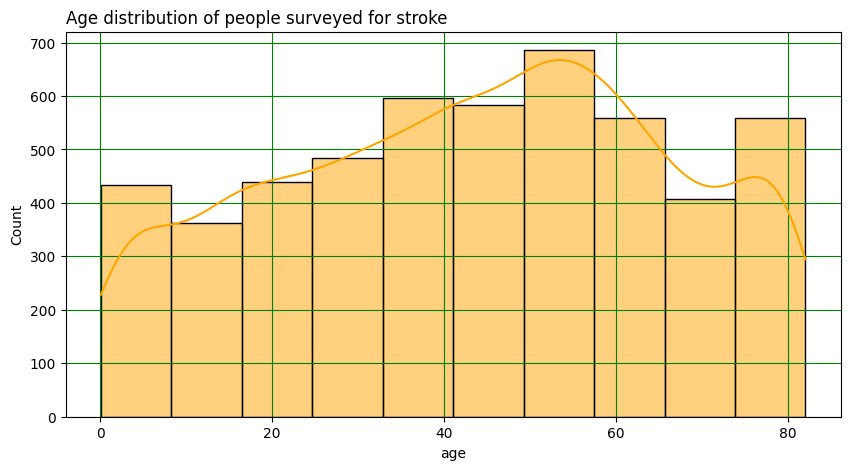

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(data['age'],kde=True,bins=10,color='orange')
plt.title('Age distribution of people surveyed for stroke',loc='left')
plt.grid(color='g',linestyle='-')
plt.show()

For stroke column

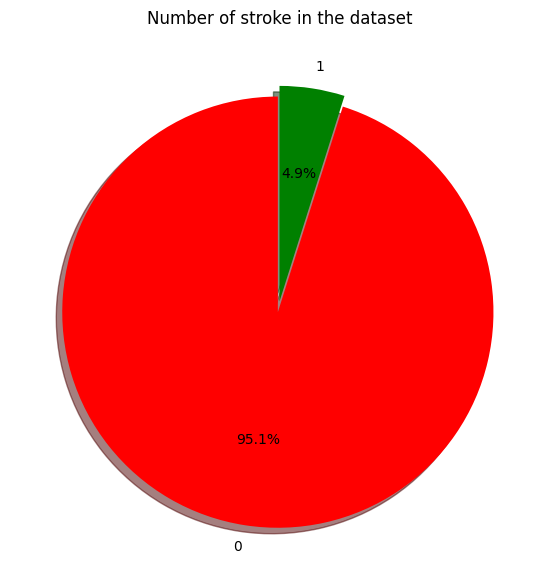

In [ ]:
labels =df['stroke'].value_counts(sort = True).index
sizes = df['stroke'].value_counts(sort = True)

colors = ["red","green"]
explode = (0.05,0)

plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)
plt.title('Number of stroke in the dataset')
plt.show()

### Gender Distribution

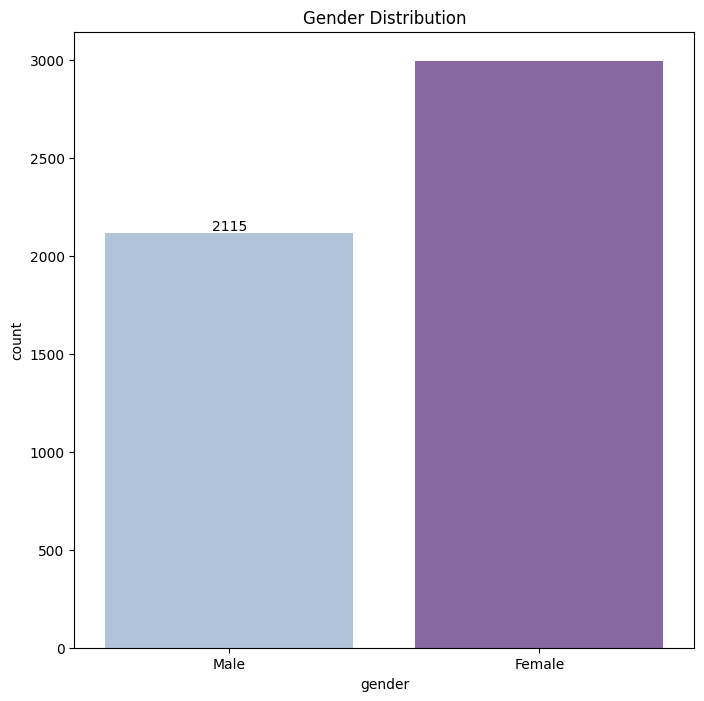

In [ ]:
plt.figure(figsize=(8,8))
ax = sns.countplot(df,x='gender',palette='BuPu')
ax.bar_label(ax.containers[0])
plt.title('Gender Distribution')
plt.show()

### Hypertension Distribution

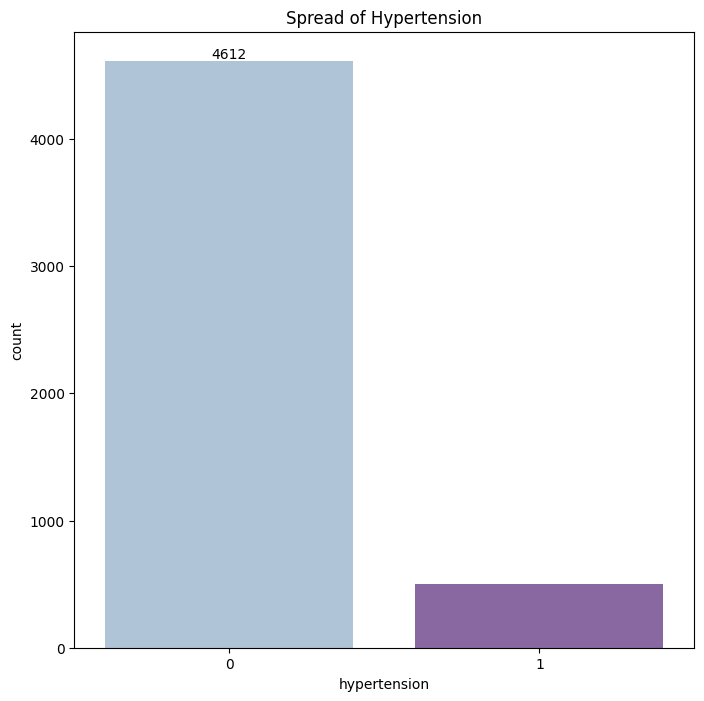

In [ ]:
plt.figure(figsize=(8,8))
ax = sns.countplot(df,x='hypertension',palette='BuPu')
ax.bar_label(ax.containers[0])
plt.title('Spread of Hypertension')
plt.show()

### Heart Disease Distribution

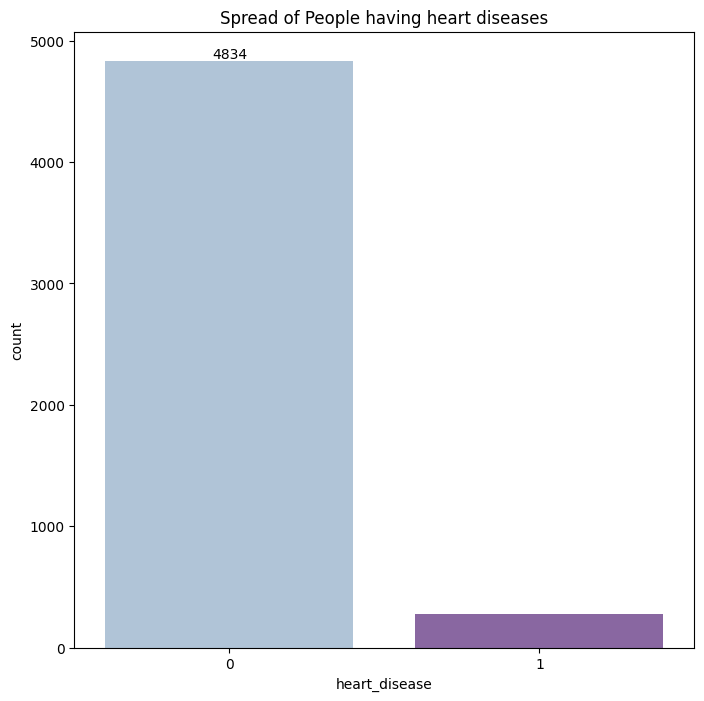

In [ ]:
plt.figure(figsize=(8,8))
ax = sns.countplot(df,x='heart_disease',palette='BuPu')
ax.bar_label(ax.containers[0])
plt.title('Spread of People having heart diseases')
plt.show()

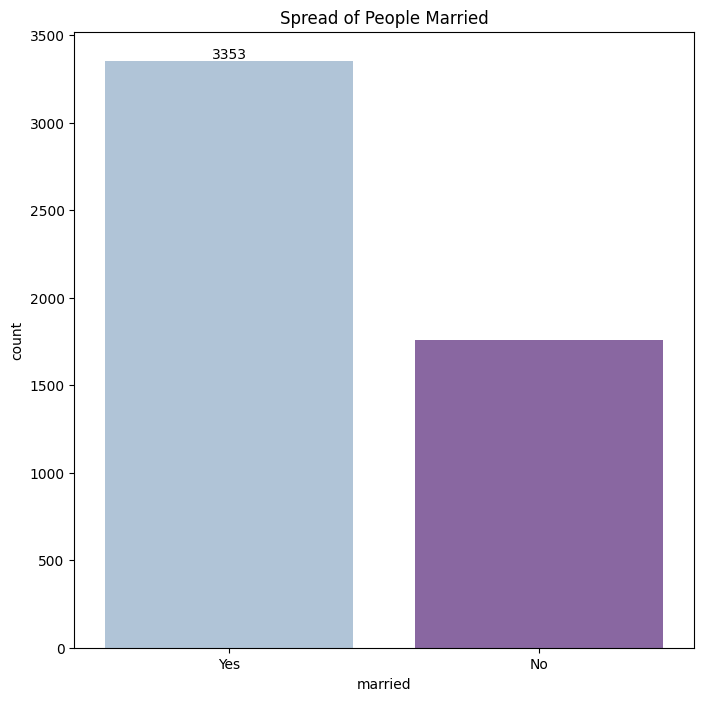

In [ ]:
plt.figure(figsize=(8,8))
ax = sns.countplot(df,x='married',palette='BuPu')
ax.bar_label(ax.containers[0])
plt.title('Spread of People Married')
plt.show()

### For Work Type,Residence and stroke

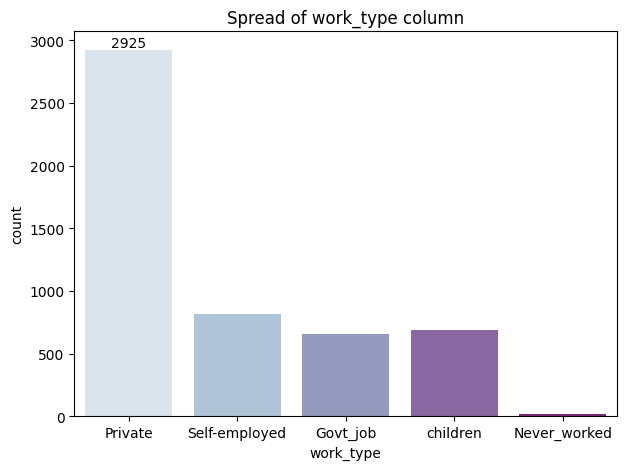

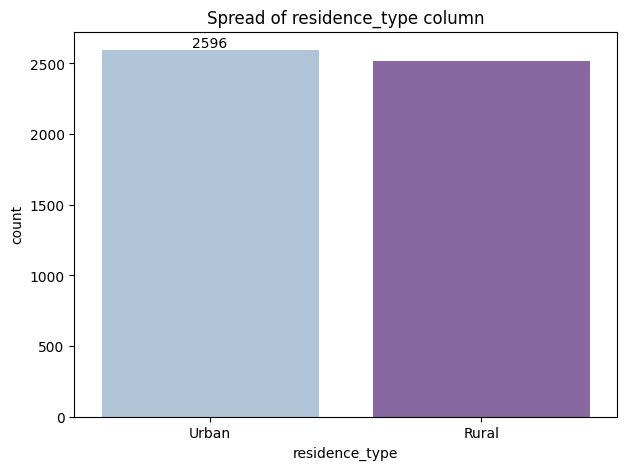

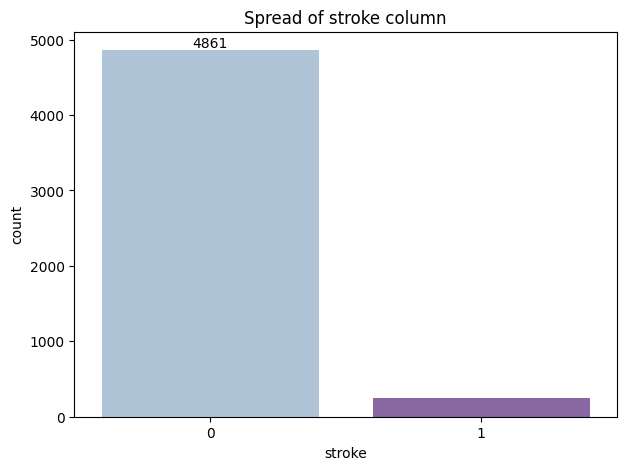

In [ ]:
columns = ['work_type','residence_type','stroke']
for col in columns:
  plt.figure(figsize=(7,5))
  ax = sns.countplot(df,x=col,palette='BuPu')
  ax.bar_label(ax.containers[0])
  plt.title(f'Spread of {col} column')
  plt.show()
  print('\n')

### Distribution of glucose and bmi column

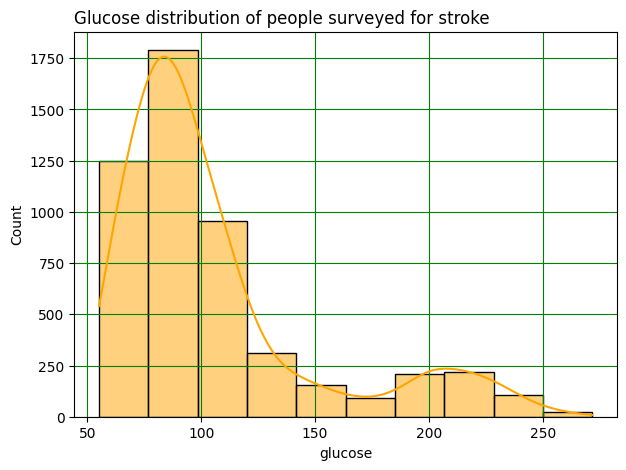

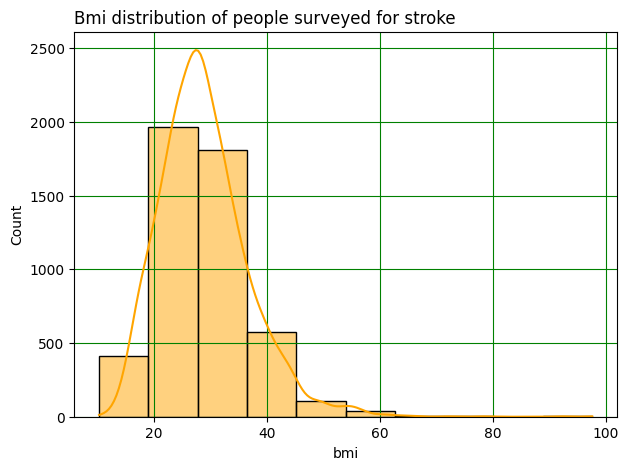

In [ ]:
columns = ['glucose','bmi']
for col in columns:
  plt.figure(figsize=(7,5))
  sns.histplot(df[col],kde=True,bins=10,color='orange')
  plt.title(f'{col.capitalize()} distribution of people surveyed for stroke',loc='left')
  plt.grid(color='g',linestyle='-')
  plt.show()
  print('\n')

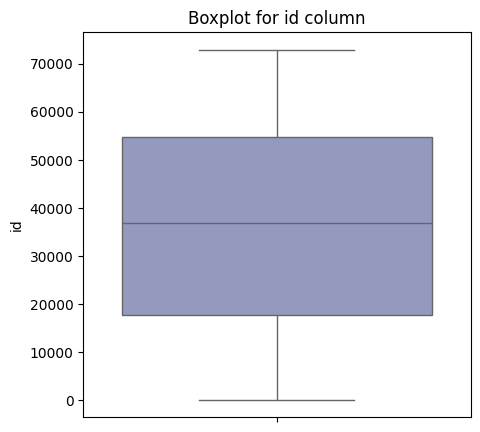

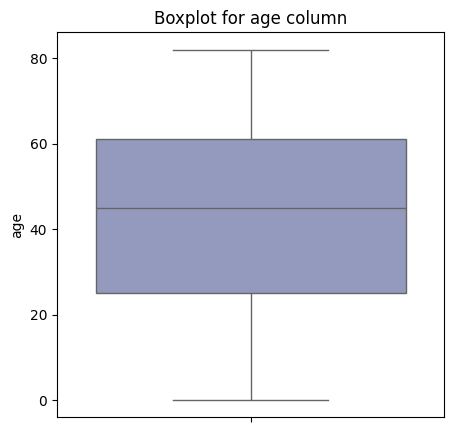

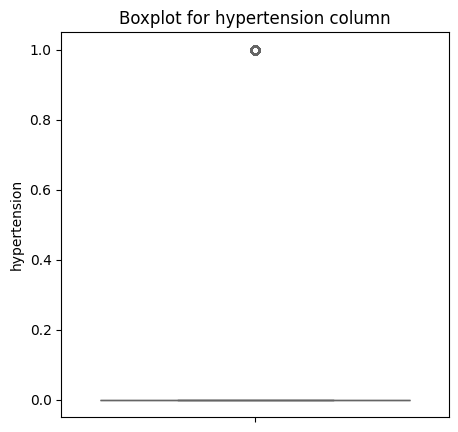

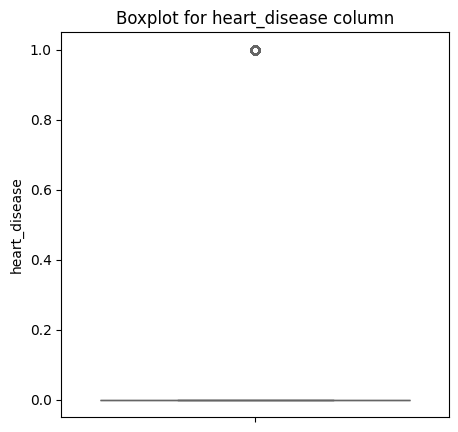

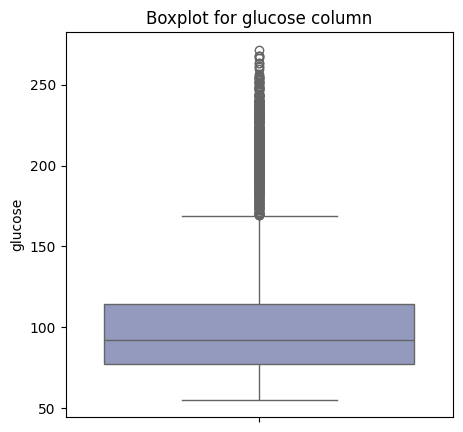

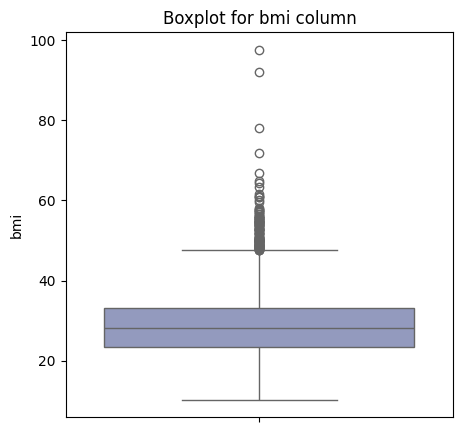

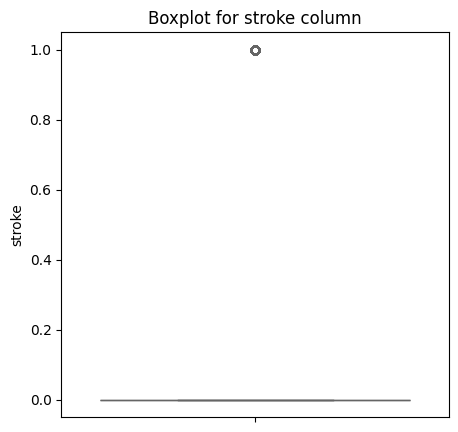

In [ ]:
for col in num_col:
  plt.figure(figsize=(5,5))
  sns.boxplot(df[col],palette='BuPu')
  plt.title(f'Boxplot for {col} column')
  plt.show()
  print('\n')

## Bi-Variate Analysis

## Checking the number of people having heart diseases by age

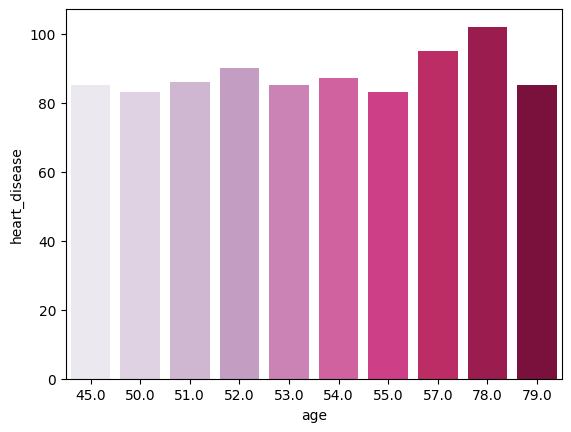

age
78.0    102
57.0     95
52.0     90
54.0     87
51.0     86
45.0     85
53.0     85
79.0     85
50.0     83
55.0     83
Name: heart_disease, dtype: int64


In [ ]:
heart_disease_by_age = df.groupby('age')['heart_disease'].count()
result=heart_disease_by_age.nlargest(10).sort_values(ascending=False)
sns.barplot(result,palette='PuRd')
plt.show()
print(result)

###Checking the correlation between glucose and bmi column using pairplot and heatmap

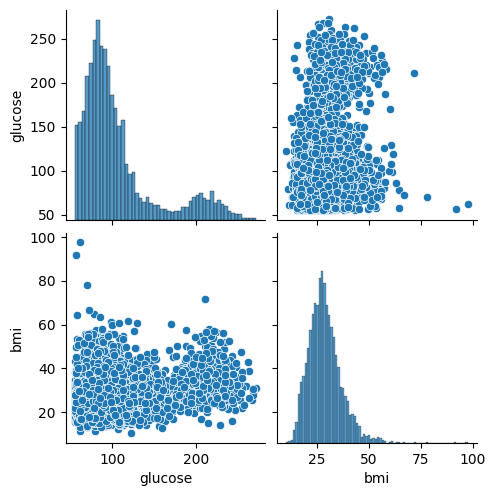

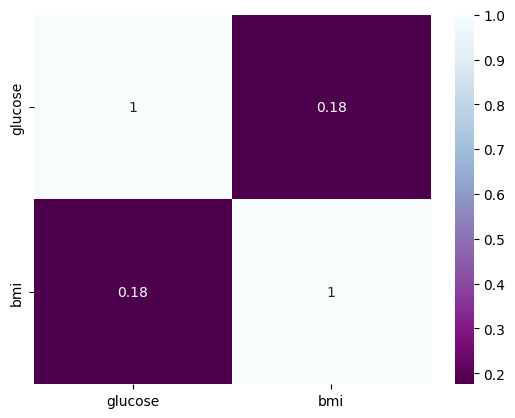

In [ ]:
res = df[['glucose','bmi']]
g=sns.pairplot(res)
plt.show()
print('\n')
sns.heatmap(res.corr(),annot=True,cmap='BuPu_r')
plt.show()

Observation :
Both glucose and bmi have slightly positive correlation

### Checking the distribution of bmi column in order to fill missing values

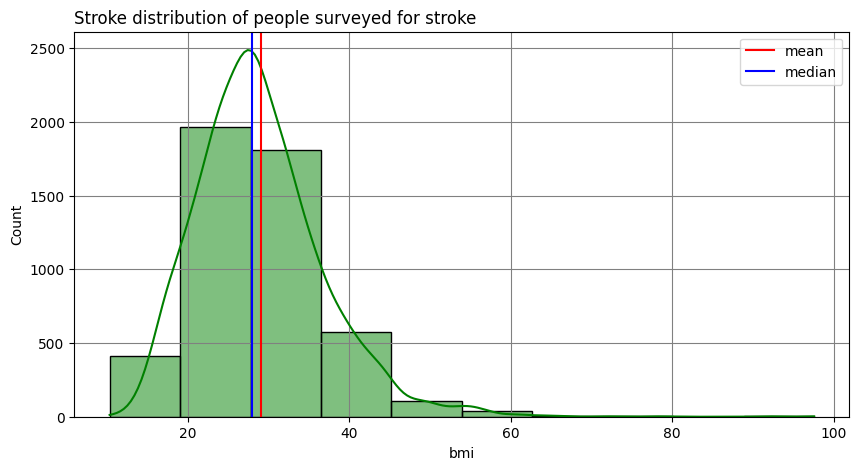

In [ ]:
mean,median = int(np.round(df['bmi'].mean(),0)),int(np.round(df['bmi'].median(),0))
plt.figure(figsize=(10,5))
sns.histplot(df['bmi'],kde=True,bins=10,color='green')
plt.axvline(x=mean, color='red', linestyle='-', label='mean')
plt.axvline(x=median, color='blue', linestyle='-', label='median')
plt.title(f'{col.capitalize()} distribution of people surveyed for stroke',loc='left')
plt.legend()
plt.grid(color='grey')
plt.show()

### Before filling the missing values I have done the data preprocessing for various categorical columns

In [ ]:
df_encoded = df.drop(columns=['id'])
df_encoded.head(2)

,gender,age,hypertension,heart_disease,married,work_type,residence_type,glucose,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly_smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


### Performing Label Encoding

In [ ]:
le = LabelEncoder()
df_encoded['gender']=le.fit_transform(df_encoded['gender'])
df_encoded['married']=le.fit_transform(df_encoded['married'])
df_encoded['residence_type']=le.fit_transform(df_encoded['residence_type'])
df_encoded.head(2)

,gender,age,hypertension,heart_disease,married,work_type,residence_type,glucose,bmi,smoking_status,stroke
0,1,67.0,0,1,1,Private,1,228.69,36.6,formerly_smoked,1
1,0,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1


### Performing One Hot Encoding

In [ ]:
work_type_array=np.array(df_encoded['work_type'])
smoking_status_array = np.array(df_encoded['smoking_status'])

ohe_wt = OneHotEncoder()
ohe_ss = OneHotEncoder()

df_encoded_wt = ohe_wt.fit_transform(work_type_array.reshape(-1,1)).toarray().astype('int64')
df_encoded_ss = ohe_ss.fit_transform(smoking_status_array.reshape(-1,1)).toarray().astype('int64')

encoded_wt_df = pd.DataFrame(df_encoded_wt,columns=ohe_wt.get_feature_names_out(['work_type']))
encoded_ss_df = pd.DataFrame(df_encoded_ss,columns=ohe_ss.get_feature_names_out(['somking_status']))

df_encoded = pd.concat([df_encoded,encoded_wt_df,encoded_ss_df],axis=1)
df_encoded.drop(columns=['work_type','smoking_status','somking_status_unknown','work_type_children'],axis=1,inplace=True)

df_encoded.head(2)

,gender,age,hypertension,heart_disease,married,residence_type,glucose,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,somking_status_formerly_smoked,somking_status_never smoked,somking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.6,1,0,0,1,0,1,0,0
1,0,61.0,0,0,1,0,202.21,NaN,1,0,0,0,1,0,1,0


###Filling up the missing values with the replace function

In [ ]:
df_encoded.replace(np.nan,df_encoded['bmi'].median(),inplace=True)
df_encoded.head(2)

,gender,age,hypertension,heart_disease,married,residence_type,glucose,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,somking_status_formerly_smoked,somking_status_never smoked,somking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.6,1,0,0,1,0,1,0,0
1,0,61.0,0,0,1,0,202.21,28.1,1,0,0,0,1,0,1,0


### bmi graph after filling the missing values

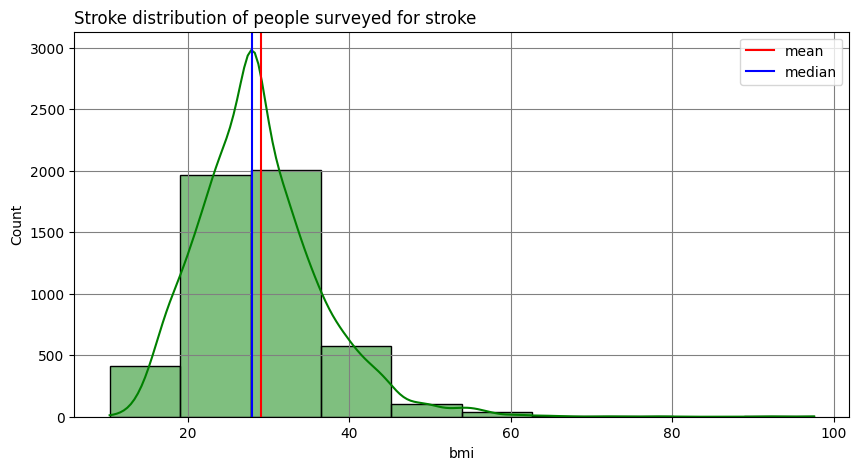

In [ ]:
mean,median = int(np.round(df_encoded['bmi'].mean(),0)),int(np.round(df_encoded['bmi'].median(),0))
plt.figure(figsize=(10,5))
sns.histplot(df_encoded['bmi'],kde=True,bins=10,color='green')
plt.axvline(x=mean, color='red', linestyle='-', label='mean')
plt.axvline(x=median, color='blue', linestyle='-', label='median')
plt.title(f'{col.capitalize()} distribution of people surveyed for stroke',loc='left')
plt.legend()
plt.grid(color='grey')
plt.show()

### Splitting the dataset into dependent (y) and independent (x) variables and then perform Oversampling for stroke column since number of target value '1' is less than that of '0'

In [ ]:
model_df = df_encoded.copy(deep=True)

x=model_df.drop(columns=['stroke'])
y=model_df['stroke']

bsmote = BorderlineSMOTE(random_state=0)
x_resampled,y_resampled = bsmote.fit_resample(x,y)

In [ ]:
y_resampled

,stroke
0,1
1,1
2,1
3,1
4,1
...,...
9717,1
9718,1
9719,1
9720,1


### Checking the balance of our target/dependent value

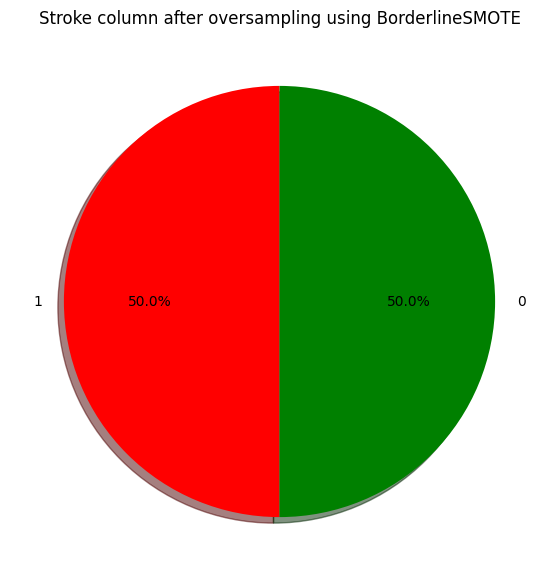

In [ ]:
labels =y_resampled.value_counts(sort = True).index
sizes = y_resampled.value_counts(sort = True)

colors = ["red","green"]

plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)
plt.title('Stroke column after oversampling using BorderlineSMOTE')
plt.show()

### Splitting the dataset into training and testing data

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3,random_state=23)
x1train,x1test,y1train,y1test = train_test_split(x_resampled,y_resampled,test_size=0.3,random_state=42)

#Image of a confusin matrix

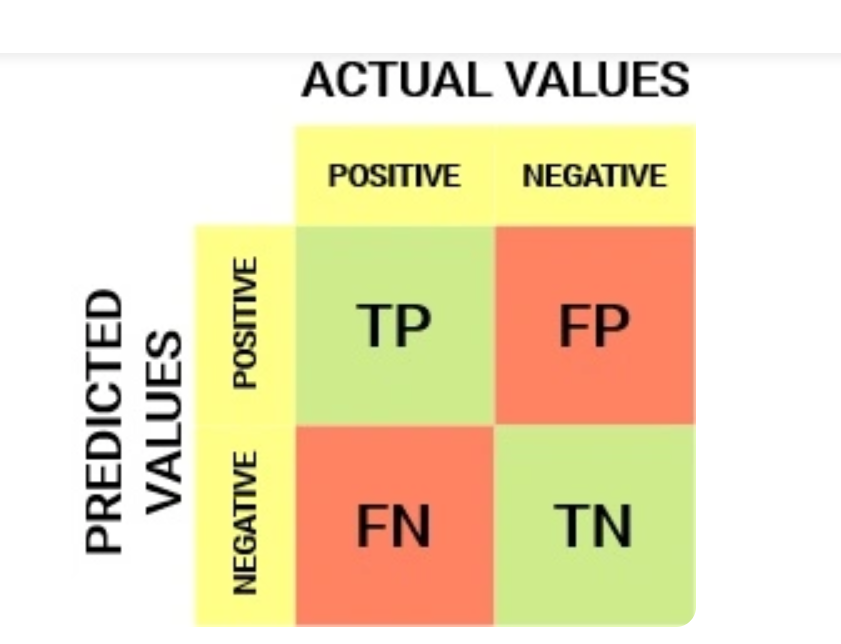

##*Formula to be used*

###1. Sensitivity / True Positive Rate / Recall

#$ TP /(TP + FN) $

###2. False Negative Rate

#$ FN /(TP + FN) $

###3. Specificity / True Negative Rate

#$ TN /(TN + FP) $

###4. False Positive Rate

#$ FP /(TN + FP) $



### 1. We will be performing **Logistic Regression** machine learning model on both original sample and resampled data and find whether this model is suitable or not using the classification metrics like accuracy score,confusion matrix,classification report

In [ ]:
log_reg = LogisticRegression()
log_reg1 = LogisticRegression()

log_reg.fit(xtrain,ytrain)

LogisticRegression()

In [ ]:
log_reg1.fit(x1train,y1train)

LogisticRegression()

In [ ]:
pred = log_reg.predict(xtest)

pred1 = log_reg.predict(x1test)

In [ ]:
pred_prob=log_reg.predict_proba(xtest)[:,1]
pred_prob1=log_reg.predict_proba(x1test)[:,1]

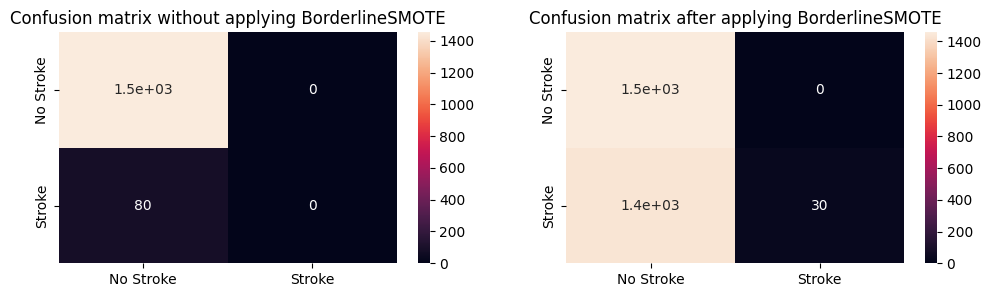

In [ ]:
labels = ['No Stroke', 'Stroke']
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(ytest,pred),annot=True,xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix without applying BorderlineSMOTE')
print('\t')
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y1test,pred1),annot=True,xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix after applying BorderlineSMOTE')
plt.show()

In [ ]:
print(f'''
       Confusion Matrix before applying BorderlineSMOTE
       in Logistic Regression
       \n{confusion_matrix(ytest,pred)}
      \nConfusion Matrix after applying BorderlineSMOTE
       in Logistic Regression
       \n{confusion_matrix(y1test,pred1)}
       ''')


       Confusion Matrix before applying BorderlineSMOTE
       in Logistic Regression 
       
[[1453    0]
 [  80    0]]
      
Confusion Matrix after applying BorderlineSMOTE
       in Logistic Regression 
       
[[1457    0]
 [1430   30]]
       


In [ ]:
print(f'''Accuracy score before applying BorderlineSMOTE
          {accuracy_score(ytest,pred)}
      \nAccuracy score after applying BorderlineSMOTE
          {accuracy_score(y1test,pred1)}
      ''')

Accuracy score before applying BorderlineSMOTE
          0.9478147423352903
      
Accuracy score after applying BorderlineSMOTE 
          0.509770311964347
      


In [ ]:
print(f''' Classification Report before applying BorderlineSMOTE\n
           {classification_report(ytest,pred)}\n
          Classification Report after applying BorderlineSMOTE\n
           {classification_report(y1test,pred1)}''')

 Classification Report before applying BorderlineSMOTE

                         precision    recall  f1-score   support

           0       0.95      1.00      0.97      1453
           1       0.00      0.00      0.00        80

    accuracy                           0.95      1533
   macro avg       0.47      0.50      0.49      1533
weighted avg       0.90      0.95      0.92      1533


          Classification Report after applying BorderlineSMOTE

                         precision    recall  f1-score   support

           0       0.50      1.00      0.67      1457
           1       1.00      0.02      0.04      1460

    accuracy                           0.51      2917
   macro avg       0.75      0.51      0.36      2917
weighted avg       0.75      0.51      0.36      2917



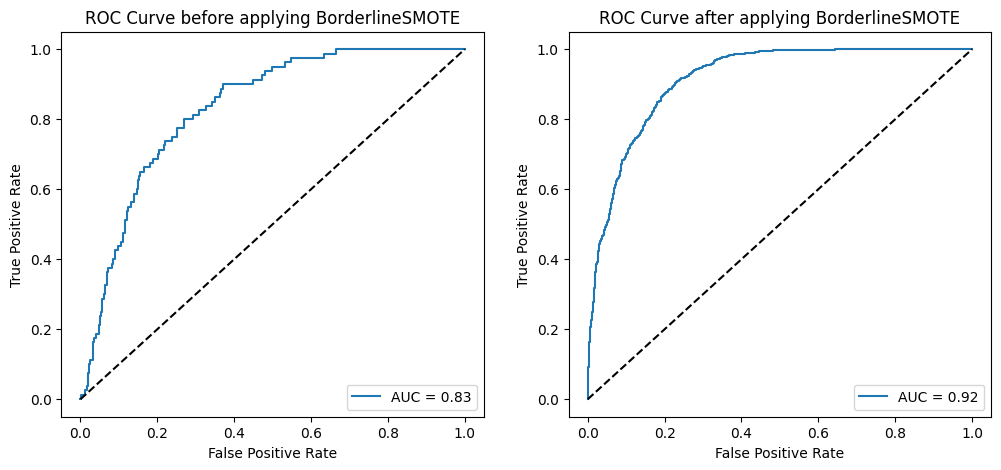

In [ ]:
fpr, tpr, threshold = roc_curve(ytest, pred_prob)
auc = roc_auc_score(ytest, pred_prob)

fpr1, tpr1, threshold1 = roc_curve(y1test, pred_prob1)
auc1 = roc_auc_score(y1test, pred_prob1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve before applying BorderlineSMOTE')
plt.legend(loc='lower right')
plt.subplot(1,2,2)
plt.plot(fpr1, tpr1, label=f'AUC = {auc1:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve after applying BorderlineSMOTE')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(f'''AUC before applying BorderlineSMOTE
            in Logistic Regression {auc}
         \n AUC after applying BorderlineSMOTE
            in Logistic Regression {auc1}''')

AUC before applying BorderlineSMOTE
            in Logistic Regression 0.8307553337921542 
         
 AUC after applying BorderlineSMOTE
            in Logistic Regression 0.9150412275176052


### *Observations*
It can be inferred that despite oversampling the model performed badly as there were a lot of false postives , hence we will further evaluate with other models

### 2. After **Logistic Regression**, we will be performing **Decision Tree Classification** machine learning model on both original sample and resampled data and find whether this model is suitable or not using the classification metrics like accuracy score,confusion matrix,classification report etc.

In [ ]:
dtc = DecisionTreeClassifier()
dtc1 = DecisionTreeClassifier()

dtc.fit(xtrain,ytrain)

DecisionTreeClassifier()

In [ ]:
dtc1.fit(x1train,y1train)

DecisionTreeClassifier()

In [ ]:
pred = dtc.predict(xtest)
pred1=dtc1.predict(x1test)

In [ ]:
print(f'''Accuracy score before applying BorderlineSMOTE
          {accuracy_score(ytest,pred)}
      \nAccuracy score after applying BorderlineSMOTE
          {accuracy_score(y1test,pred1)}
      ''')

Accuracy score before applying BorderlineSMOTE
          0.9054142204827136
      
Accuracy score after applying BorderlineSMOTE 
          0.9410353102502571
      


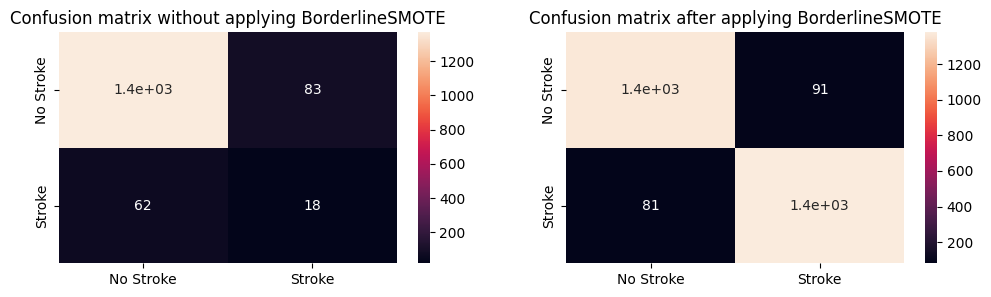

In [ ]:
labels = ['No Stroke', 'Stroke']
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(ytest,pred),annot=True,xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix without applying BorderlineSMOTE')
print('\t')
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y1test,pred1),annot=True,xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix after applying BorderlineSMOTE')
plt.show()

In [ ]:
print(f'''
       Confusion Matrix before applying BorderlineSMOTE
       in DecisionTreeClassifier
       \n{confusion_matrix(ytest,pred)}
      \nConfusion Matrix after applying BorderlineSMOTE
       in DecisionTreeClassifier
       \n{confusion_matrix(y1test,pred1)}
       ''')


       Confusion Matrix before applying BorderlineSMOTE
       in DecisionTreeClassifier 
       
[[1370   83]
 [  62   18]]
      
Confusion Matrix after applying BorderlineSMOTE
       in DecisionTreeClassifier 
       
[[1366   91]
 [  81 1379]]
       


In [ ]:
pred_prob=dtc.predict_proba(xtest)[:,1]
pred_prob1=dtc1.predict_proba(x1test)[:,1]

In [ ]:
print(f''' Classification Report before applying BorderlineSMOTE\n
           {classification_report(ytest,pred)}\n
          Classification Report after applying BorderlineSMOTE\n
           {classification_report(y1test,pred1)}''')

 Classification Report before applying BorderlineSMOTE

                         precision    recall  f1-score   support

           0       0.96      0.94      0.95      1453
           1       0.18      0.23      0.20        80

    accuracy                           0.91      1533
   macro avg       0.57      0.58      0.57      1533
weighted avg       0.92      0.91      0.91      1533


          Classification Report after applying BorderlineSMOTE

                         precision    recall  f1-score   support

           0       0.94      0.94      0.94      1457
           1       0.94      0.94      0.94      1460

    accuracy                           0.94      2917
   macro avg       0.94      0.94      0.94      2917
weighted avg       0.94      0.94      0.94      2917



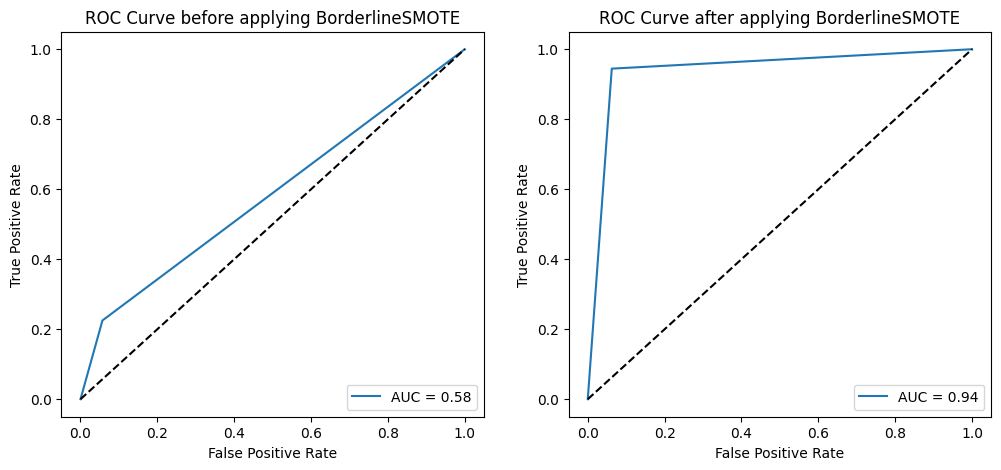

In [ ]:
fpr, tpr, threshold = roc_curve(ytest, pred_prob)
auc = roc_auc_score(ytest, pred_prob)

fpr1, tpr1, threshold1 = roc_curve(y1test, pred_prob1)
auc1 = roc_auc_score(y1test, pred_prob1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve before applying BorderlineSMOTE')
plt.legend(loc='lower right')
plt.subplot(1,2,2)
plt.plot(fpr1, tpr1, label=f'AUC = {auc1:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve after applying BorderlineSMOTE')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(f'''AUC before applying BorderlineSMOTE
            in DecisionTreeClassifier {auc}
         \n AUC after applying BorderlineSMOTE
            in DecisionTreeClassifier {auc1}''')

AUC before applying BorderlineSMOTE
            in DecisionTreeClassifier 0.58393840330351 
         
 AUC after applying BorderlineSMOTE
            in DecisionTreeClassifier 0.9410317221537969


### *Observations*
We can observe that this model performed much better after oversampling was done,but on the original dataset it performed badly hence we can conclude that the decision tree performed the best .

### 3. After finding out, that the Decision Tree Classifier works best for this dataset, we will be further checking if we can create better model by performing Hyperparameter Tuning on Decision Tree Classifier

## *Steps to be performed*
1. Create a parameter grid
2. Insert the model and parameter grid inside of GridSearchCV
3. Find out the best decision tree and finally apply it on the model and find the metrics of this model

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
gs = GridSearchCV(dtc1, param_grid,cv=5)

gs.fit(x1train,y1train)

print('Best parameter ',gs.best_params_)

Best parameter  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [ ]:
pred = gs.best_estimator_.predict(x1test)

In [ ]:
print(f'''Accuracy score after applying GridSearchCV
          {accuracy_score(y1test,pred)}
      ''')

Accuracy score after applying GridSearchCV
          0.9389784024682893
      


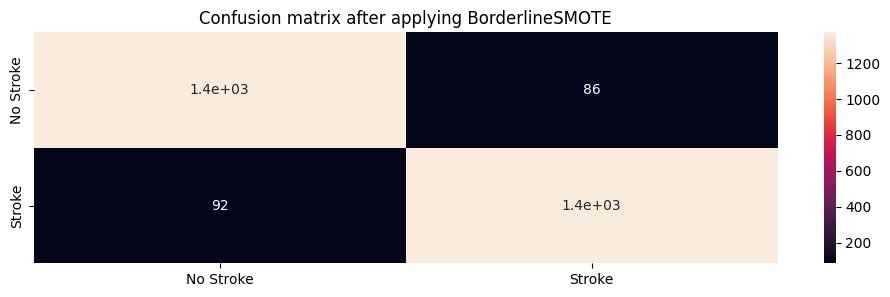

In [ ]:
labels = ['No Stroke', 'Stroke']
plt.figure(figsize=(12,3))
sns.heatmap(confusion_matrix(y1test,pred),annot=True,xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix after applying BorderlineSMOTE')
plt.show()

In [ ]:
print(f'''\nConfusion Matrix after applying GridSearchCV
       in DecisionTreeClassifier
       \n{confusion_matrix(y1test,pred1)}
       ''')


Confusion Matrix after applying GridSearchCV
       in DecisionTreeClassifier 
       
[[1366   91]
 [  81 1379]]
       


In [ ]:
print(f'''Classification Report after applying GridSearchCV in Decision Tree Classifier\n
          {classification_report(y1test,pred)}''')

Classification Report after applying GridSearchCV in Decision Tree Classifier

                        precision    recall  f1-score   support

           0       0.94      0.94      0.94      1457
           1       0.94      0.94      0.94      1460

    accuracy                           0.94      2917
   macro avg       0.94      0.94      0.94      2917
weighted avg       0.94      0.94      0.94      2917



### *Observations*

After performing the Hyperparameter Tuning , we can clearly see that to some extent it performed better than the Original Decision Tree Classifier as it was correctly able to classify people who had stroke and those who didn't